In [41]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

In [61]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import numpy as np

# Preprocess Data

In [43]:
df = pd.read_csv("TRAIN_DATA.csv")
df.head(5)

,TRAIN,OUTPUT
0,try book apartment trip hong kong choose one c...,0
1,browse show first page recommendation normally...,0
2,recently make reservation however need change ...,0
3,look fantastic sound fantastic fantastic prope...,0
4,quite simply read read read thing complete ref...,0


In [44]:
df.groupby('OUTPUT').describe()
43/157

0.27388535031847133

In [45]:
df_pf = df[df['OUTPUT']==0]
df_pf.shape

(157, 2)

In [46]:
df_of = df[df['OUTPUT']==1]
df_of.shape

(43, 2)

In [47]:
df_pf_downsized = df_pf.sample(df_of.shape[0])
df_pf_downsized.shape

(43, 2)

In [48]:
df_balanced = pd.concat([df_pf_downsized, df_of])
df_balanced.shape

(86, 2)

In [49]:
df_balanced['OUTPUT'].value_counts()

0    43
1    43
Name: OUTPUT, dtype: int64

In [50]:
df_balanced.sample(5)

,TRAIN,OUTPUT
174,short sign look deal sardinia lot choice put i...,0
78,find site tommy sotomayor youtube personality ...,1
113,recently rent place home city los angeles one ...,1
175,recently rent room house lanai 4 night lliai s...,1
28,terrible experience go avignon france last fri...,1


# Model Creation

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

X_train, X_test, y_train, y_test = train_test_split(df_balanced['TRAIN'], df_balanced['OUTPUT'], stratify=df_balanced['OUTPUT'])

In [52]:
X_train.head(5)

84     worked motel say guest receive 10 time well se...
77     property rent sub par dump issue scam artist h...
143    despite pay 8 month advance host barcelona uni...
160    care guest pay fee support company recent trip...
127    ik heb alleen maar slechte ervaringen bij ik g...
Name: TRAIN, dtype: object

In [53]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [54]:
def get_sentence_embeding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

# Example 
get_sentence_embeding([
                       "Gross house with rats",
                       "App and website were broken when booking"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.79434836, -0.30136648, -0.0502823 , ...,  0.20825766,
        -0.55898917,  0.8370715 ],
       [-0.80192316, -0.43536097, -0.86520225, ..., -0.66263014,
        -0.60623837,  0.81479   ]], dtype=float32)>

In [55]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Netowrk Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct Final Model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [56]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [57]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [58]:
model.fit(X_train,y_train, epochs=10)

Epoch 1/10
2/2 [==============================] - 17s 384ms/step - loss: 0.7004 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4688
Epoch 2/10
2/2 [==============================] - 1s 312ms/step - loss: 0.7196 - accuracy: 0.4062 - precision: 0.3750 - recall: 0.2812
Epoch 3/10
2/2 [==============================] - 1s 312ms/step - loss: 0.6893 - accuracy: 0.5312 - precision: 0.5357 - recall: 0.4688
Epoch 4/10
2/2 [==============================] - 1s 311ms/step - loss: 0.7107 - accuracy: 0.5156 - precision: 0.5135 - recall: 0.5938
Epoch 5/10
2/2 [==============================] - 1s 314ms/step - loss: 0.6982 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5938
Epoch 6/10
2/2 [==============================] - 1s 312ms/step - loss: 0.7080 - accuracy: 0.4531 - precision: 0.4615 - recall: 0.5625
Epoch 7/10
2/2 [==============================] - 1s 311ms/step - loss: 0.6999 - accuracy: 0.5156 - precision: 0.5135 - recall: 0.5938
Epoch 8/10
2/2 [==============================] - 1s 3

In [59]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.7107 - accuracy: 0.4091 - precision: 0.4000 - recall: 0.3636


[0.7106882333755493,
 0.40909090638160706,
 0.4000000059604645,
 0.3636363744735718]

In [62]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

# Turn predictions back into 0 or 1 
y_predicted = np.where(y_predicted > 0.5, 1, 0)

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[5, 6],
       [7, 4]])

Text(33.0, 0.5, 'Truth')

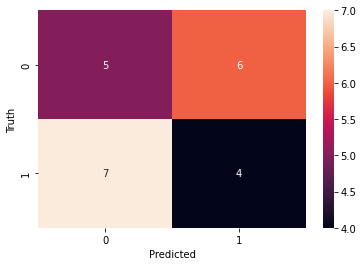

In [64]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [66]:
print(classification_report(y_test, y_predicted))

# NOTE f1-score is low. Try increasing sample size? Unknown discuss further

              precision    recall  f1-score   support

           0       0.42      0.45      0.43        11
           1       0.40      0.36      0.38        11

    accuracy                           0.41        22
   macro avg       0.41      0.41      0.41        22
weighted avg       0.41      0.41      0.41        22

